# Loading the data

C:\Users\pc\AppData\Local\Temp\ipykernel_5288\1913181248.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_5288\1913181248.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)


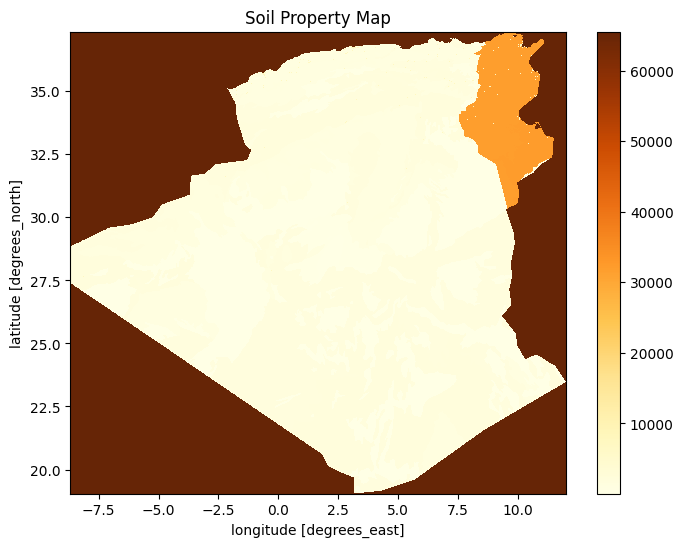

In [ ]:
import pyodbc
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extract_smu_ids(countries):
    countries = world[world["NAME"].isin(countries)]

    # ensure CRS match
    countries = countries.to_crs(rds.rio.crs)

    # clip raster to Algeria + Tunisia
    clipped = rds.rio.clip(countries.geometry, from_disk=True)
    # print("Clipping done.")
    transform = clipped.rio.transform()

    # Get pixel indices (ignore band dimension)
    rows, cols = np.indices(clipped.shape[1:])

    # Convert pixel indices to geographic coordinates
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    # print("Coordinate extraction done.")
    lons = np.array(xs).flatten()
    lats = np.array(ys).flatten()

    # Flatten raster values
    smu_ids = clipped.values.flatten()

    # Remove NaN values
    mask = ~np.isnan(smu_ids)
    # print("NaN removal done.")

    df = pd.DataFrame({
        "lon": lons[mask],
        "lat": lats[mask],
        "HWSD2_SMU_ID": smu_ids[mask].astype(int)
    })
    # print("DataFrame creation done.")
    return df, clipped
def filter_smu_layers(smu_ids):
    # Filter to selected SMU_IDs
    layers_filtered = layers[layers["HWSD2_SMU_ID"].isin(smu_ids)]

    return layers_filtered

mdb_path = r"../local_dataset/raw/soil/HWSD2.mdb"
conn_str = (
    r"DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};"
    f"DBQ={mdb_path};"
)
conn = pyodbc.connect(conn_str)

smu = pd.read_sql("SELECT * FROM HWSD2_SMU", conn)
layers = pd.read_sql("SELECT * FROM HWSD2_LAYERS", conn)
world = gpd.read_file(r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp")
raster_path = r"../local_dataset/raw/soil/HWSD2.bil"
rds = rioxarray.open_rasterio(raster_path)


smu_ids, clipped_rds = extract_smu_ids(["Algeria", "Tunisia"])
# smu_ids = (
#     smu_ids.groupby("HWSD2_SMU_ID")[["lon", "lat"]]
#     .mean()  # centroid per SMU
#     .reset_index()
# )

# print("SMU ID extraction complete.")

layers = filter_smu_layers(smu_ids["HWSD2_SMU_ID"])
# print("Layer filtering complete.")

layers = layers[layers["LAYER"] == "D1"]
useful_columns = [
    "COARSE", "SAND", "SILT", "CLAY", "TEXTURE_USDA", "TEXTURE_SOTER",
    "BULK", "REF_BULK", "ORG_CARBON", "PH_WATER", "TOTAL_N", "CN_RATIO",
    "CEC_SOIL", "CEC_CLAY", "CEC_EFF", "TEB", "BSAT", "ALUM_SAT", "ESP",
    "TCARBON_EQ", "GYPSUM", "ELEC_COND",
]
layers = layers[useful_columns]

clipped_rds = clipped_rds.squeeze("band", drop=True)
clipped_rds.plot(cmap="YlOrBr", robust=True, figsize=(8, 6))
plt.title("Soil Property Map")
plt.show()


# Analysis part

In [4]:
import math

print(f"Shape {layers.shape}")
print("=== Data types per column ===")
print(layers.dtypes)

Shape (858, 22)
=== Data types per column ===
COARSE             int64
SAND               int64
SILT               int64
CLAY               int64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL           int64
CEC_CLAY           int64
CEC_EFF          float64
TEB              float64
BSAT               int64
ALUM_SAT           int64
ESP                int64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND          int64
dtype: object


# Missing values in each column 

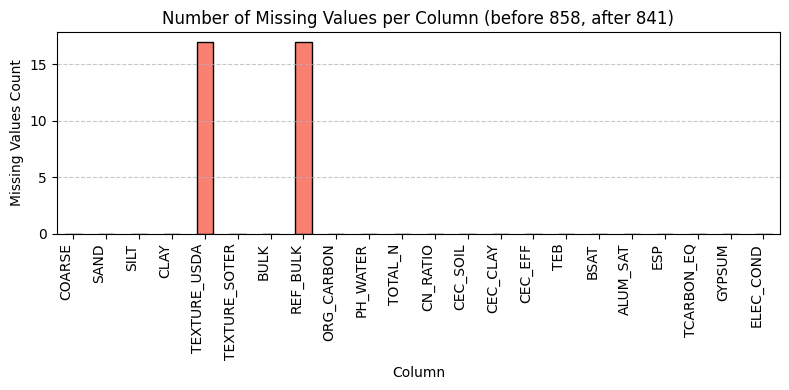

In [ ]:

missing_values_percentage = layers.isnull().sum()
old_number_of_rows = layers.shape[0]
plt.figure(figsize=(8,4))
missing_values_percentage.plot(kind='bar', color='salmon', edgecolor='black')
new_number_of_rows = layers.dropna().shape[0]

plt.title(f"Number of Missing Values per Column (before {old_number_of_rows}, after {new_number_of_rows})")
plt.ylabel("Missing Values Count")
plt.xlabel("Column")
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Removing Non numiric attributes and Fix Missing values

In [ ]:
numeric_cols = layers.select_dtypes(include=['number'])
numeric_cols = numeric_cols.fillna(numeric_cols.mean())

# Univariate Analysis

In [ ]:
print("=== Univariate Analysis === ")
print(f"=== Mean ===\n{numeric_cols.mean()}")
print(f"===  Standard Deviation ===\n{numeric_cols.std()}")
print(f"===  Minimum ===\n{numeric_cols.min()}")
print(f"===  Maximum ===\n{numeric_cols.max()}")
print(f"===  Median ===\n{numeric_cols.median()}")

=== Univariate Analysis === 
=== Mean ===
 COARSE          11.784382
SAND            47.068765
SILT            29.511655
CLAY            21.224942
TEXTURE_USDA     8.971463
BULK             1.329837
REF_BULK         1.714614
ORG_CARBON       0.840097
PH_WATER         7.476340
TOTAL_N          0.870070
CN_RATIO         9.709790
CEC_SOIL        15.361305
CEC_CLAY        58.214452
CEC_EFF         36.227273
TEB             35.252914
BSAT            91.510490
ALUM_SAT         0.431235
ESP              6.775058
TCARBON_EQ       9.110956
GYPSUM           4.362238
ELEC_COND        2.096737
dtype: float64
===  Standard Deviation ===
COARSE           9.925340
SAND            15.910959
SILT             8.925622
CLAY            10.293000
TEXTURE_USDA     2.398783
BULK             0.746249
REF_BULK         0.129918
ORG_CARBON       0.947115
PH_WATER         1.727291
TOTAL_N          0.802542
CN_RATIO         2.429577
CEC_SOIL         7.600743
CEC_CLAY        17.014529
CEC_EFF         23.586250
TEB 

# Unique numeric values in integer column 

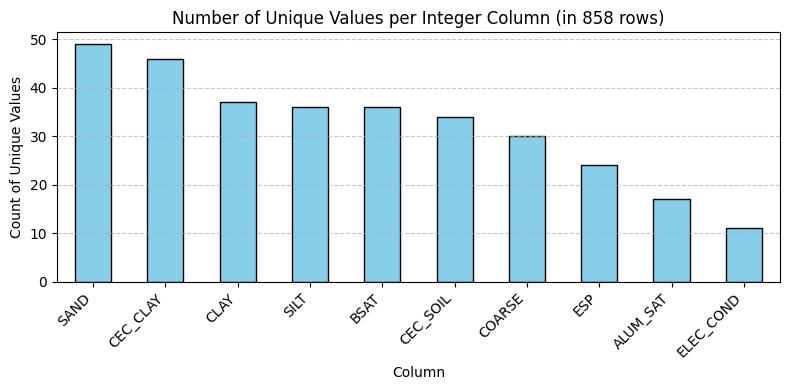

In [ ]:

int_cols = numeric_cols.select_dtypes(include="int")
unique_counts = int_cols.nunique().sort_values(ascending=False)

plt.figure(figsize=(8,4))
unique_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title(f"Number of Unique Values per Integer Column (in {layers.shape[0]} rows)")
plt.ylabel("Count of Unique Values")
plt.xlabel("Column")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Value distribution and outliers for numeric columns

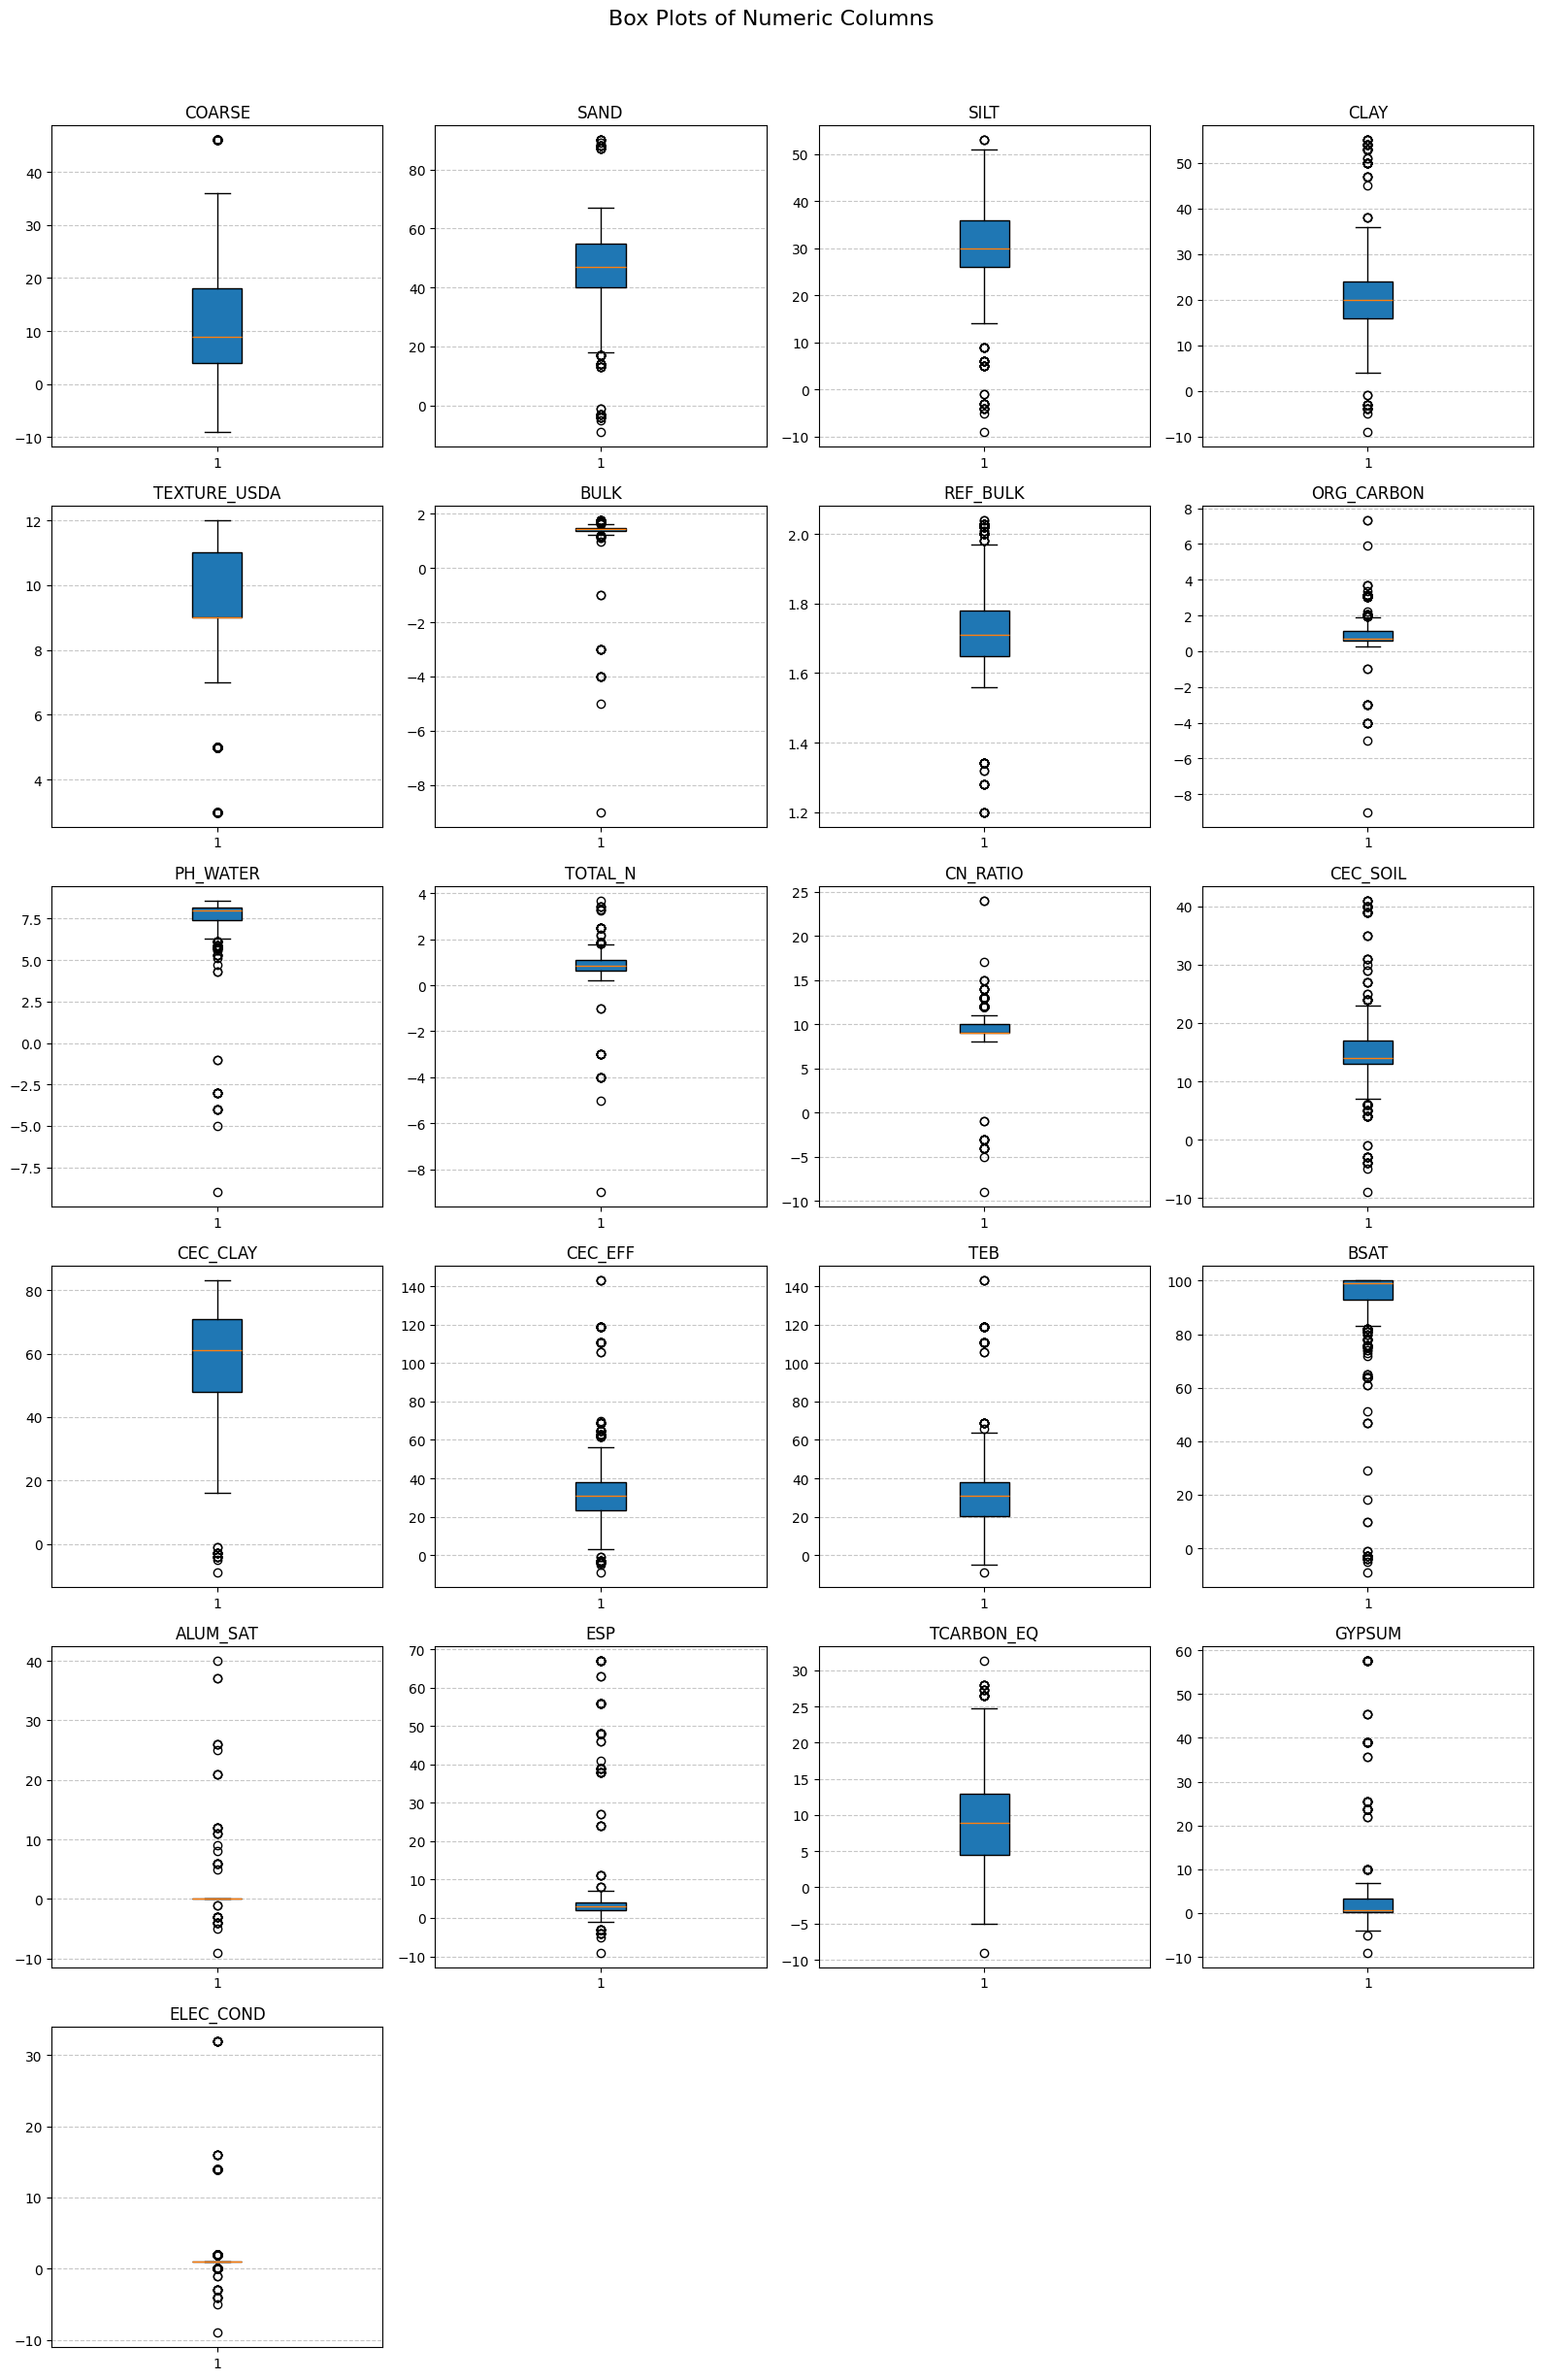

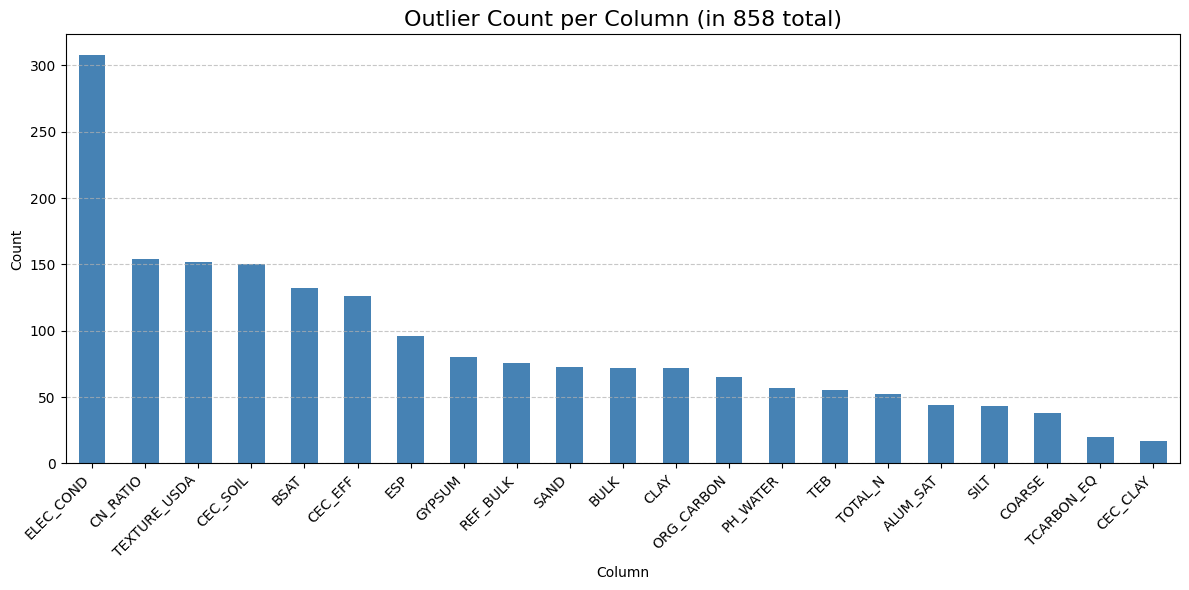

In [ ]:


n = len(numeric_cols.columns)
cols_per_row = 4  # you can change to 3 or 5 depending on your screen
rows = math.ceil(n / cols_per_row)

plt.figure(figsize=(cols_per_row * 4, rows * 4))
plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
for i, col in enumerate(numeric_cols.columns, 1):
    plt.subplot(rows, cols_per_row, i)
    plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
    plt.title(col)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()





Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
is_outlier = (numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))
outlier_counts = is_outlier.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
outlier_counts.plot(kind="bar", color="steelblue")
plt.title(f"Outlier Count per Column (in {len(numeric_cols)} total)", fontsize=16)
plt.xlabel("Column")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



# Correlation analysis

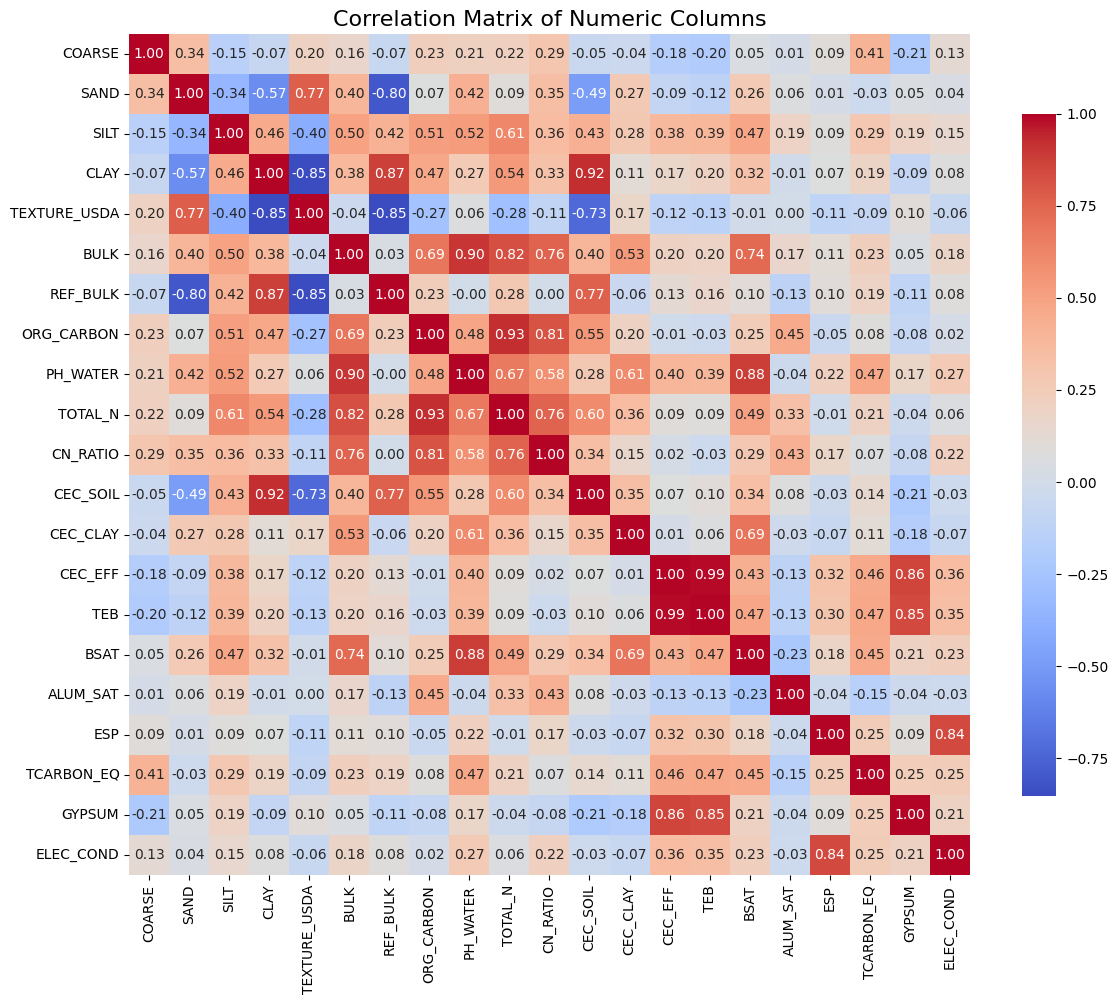

In [ ]:


# Correlation analysis
correlation_matrix = numeric_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Numeric Columns", fontsize=16)
plt.tight_layout()
plt.show()

# Exporting cleaned dataset

In [ ]:

# =========================
# ======= EXPORTING =======
# =========================

# layers_full = layers.merge(smu_ids, on="HWSD2_SMU_ID", how="left")
# print("Merging complete.")



# layers_full.to_csv(r"dataset/soil_full.csv", index=False)
# print("CSV export complete.")

# xarray_layers_full = xarray.Dataset.from_dataframe(layers_full)
# xarray_layers_full.to_netcdf(r"dataset/soil_full.nc")
# print("NetCDF export complete.")

# nc_layers_full = xarray.open_dataset("dataset/soil/HWSD2_Full.nc")
# layers_full = nc_layers_full.to_dataframe().reset_index(drop=True)
# print(layers_full.head())
